# Learning from Logged Bandit Feedbacks

One of the most common ways that recommender systems are developed in practice involves building **models** trained on the historical behaviour of the running policy.  This is to be distinguished from bandit approaches such as _Upper Confidence Bound_ or _Thompson Sampling_ or _Full Reinforcement Learning_ as in these systems there is no clear separation between a learning stage and an acting stage.  In the approaches considered here, we first learn a model and then deploy a static model that does not change further.

Here we describe a simple supervised approach where we model the probability of the click conditional upon features that are created from a combination of the user's attributes and the recommendation.

# The Data

In [3]:
import gym, reco_gym
from copy import deepcopy
from reco_gym import env_1_args
import matplotlib.pyplot as plt
import numpy as np
import pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = [6, 3]

ABTestNumberOfUsers = 100
RandomSeed = 42
NumberOfProducts = 10

NumberOfSamples = 20

env_1_args['random_seed'] = RandomSeed
env_1_args['num_products'] = NumberOfProducts
env_1_args['K'] = 5
env_1_args['number_of_flips'] = 1

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [4]:
data = deepcopy(env).generate_logs(ABTestNumberOfUsers)

Let's examine the content of the logs.

In [5]:
data[:NumberOfSamples]

,a,c,ps,ps-a,t,u,v,z
0,NaN,NaN,NaN,None,0,0,0.0,organic
1,3.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1,0,NaN,bandit
2,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",2,0,NaN,bandit
3,5.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",3,0,NaN,bandit
4,NaN,NaN,NaN,None,0,1,1.0,organic
5,2.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1,1,NaN,bandit
6,8.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",2,1,NaN,bandit
7,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",3,1,NaN,bandit
8,NaN,NaN,NaN,None,4,1,4.0,organic
9,NaN,NaN,NaN,None,5,1,4.0,organic


In [6]:
print("Data Shape:", data.shape)

Data Shape: (9822, 8)


Here is the data the following columns are present:
* **`t`**—_`Time`_. Currently, _`Time`_ reflects the order of _`Events`_ but it does **not** represent the notion of the time in a physical sense.
* **`u`**—_`User`_.
* **`z`**—_`Event Type`_. There are two types of _`Events`_: _Organic_ and _Bandit_.
* **`v`**—_`View`_. The column shows which _`Product`_ was shown to a _`User`_ in an _Organic_ _`Event`_.
* **`a`**—_`Action`_. Currently, _`Action`_ is a _`Product`_ that was provided to a _`User`_ during a _Bandit_ _`Event`_.
* **`c`**—_`Click`_. This is a _Reward_ for an _`Action`_ provided by the _`Agent`_.
* **`ps`**—Probability of selecting a particular _`Action`_.

**Note #1:** _`Time`_, _`User`_, _`Views`_, and _`Actions`_ **all** them start with _`0`_.

**Note #2:** For any _`User`_, _Organic_ _`Event`_ _**always**_ precedes a _Bandit_ _`Event`_.

## Data Analysis
Let's analyse these histograms:
* _Actions per Product_
* _Clicks per Product_
* _Views per Product_.

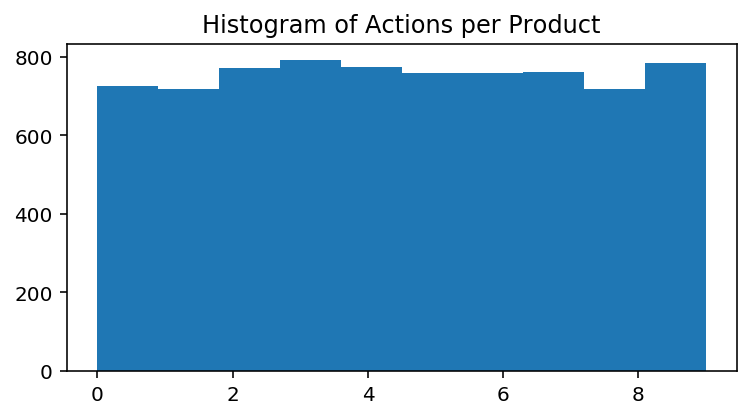

In [7]:
_, ax = plt.subplots()
ax.set_title('Histogram of Actions per Product')

ax.hist(data[data['z'] == 'bandit']['a'])
plt.show()

It is evident that all _`Actions`_ are _*evenly*_ distributed.
That is an expected behaviour because *all* _`Actions`_ are randomly applied for all _Bandit_ _`Events`_.

Clicks:  [11.0, 7.0, 12.0, 7.0, 11.0, 10.0, 3.0, 8.0, 2.0, 15.0]


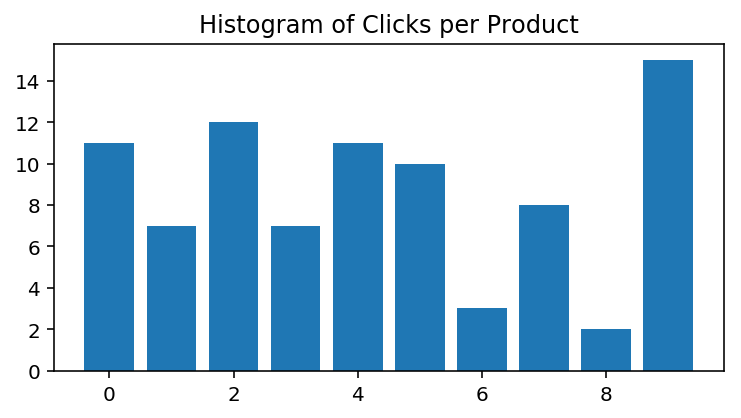

In [8]:
clicks = []
bandits = data[data['z'] == 'bandit']
for product_id in range(NumberOfProducts):
    actions = bandits[bandits['a'] == product_id]
    clicks.append(np.sum(actions[actions['c'] == 1]['c']))
    
print("Clicks: ", clicks)

_, ax = plt.subplots()
ax.set_title('Histogram of Clicks per Product')

ax.bar(range(NumberOfProducts), clicks)
plt.show()

Views:  [271, 60, 11, 158, 714, 287, 62, 123, 71, 504]


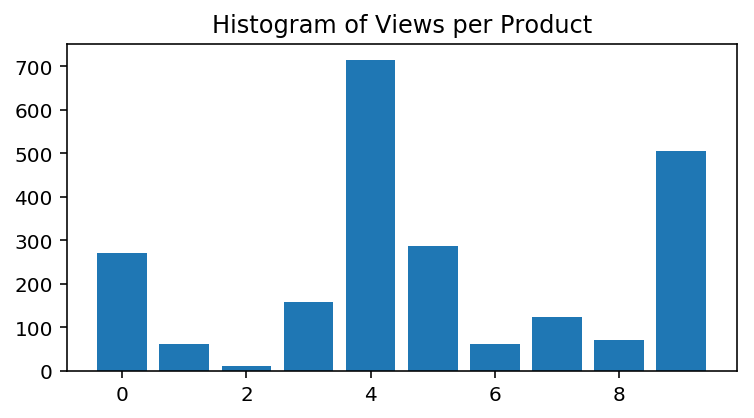

In [9]:
organics = data[data['z'] == 'organic']

views = []
for product_id in range(NumberOfProducts):
    views.append(organics[organics['v'] == product_id].shape[0])

print("Views: ", views)

_, ax = plt.subplots()
ax.set_title('Histogram of Views per Product')

ax.bar(range(NumberOfProducts), views)
plt.show()

As our analysis is based on _Click-Through Rates_ (_CTR_), let's build dependencies of CTR from the number of samples.

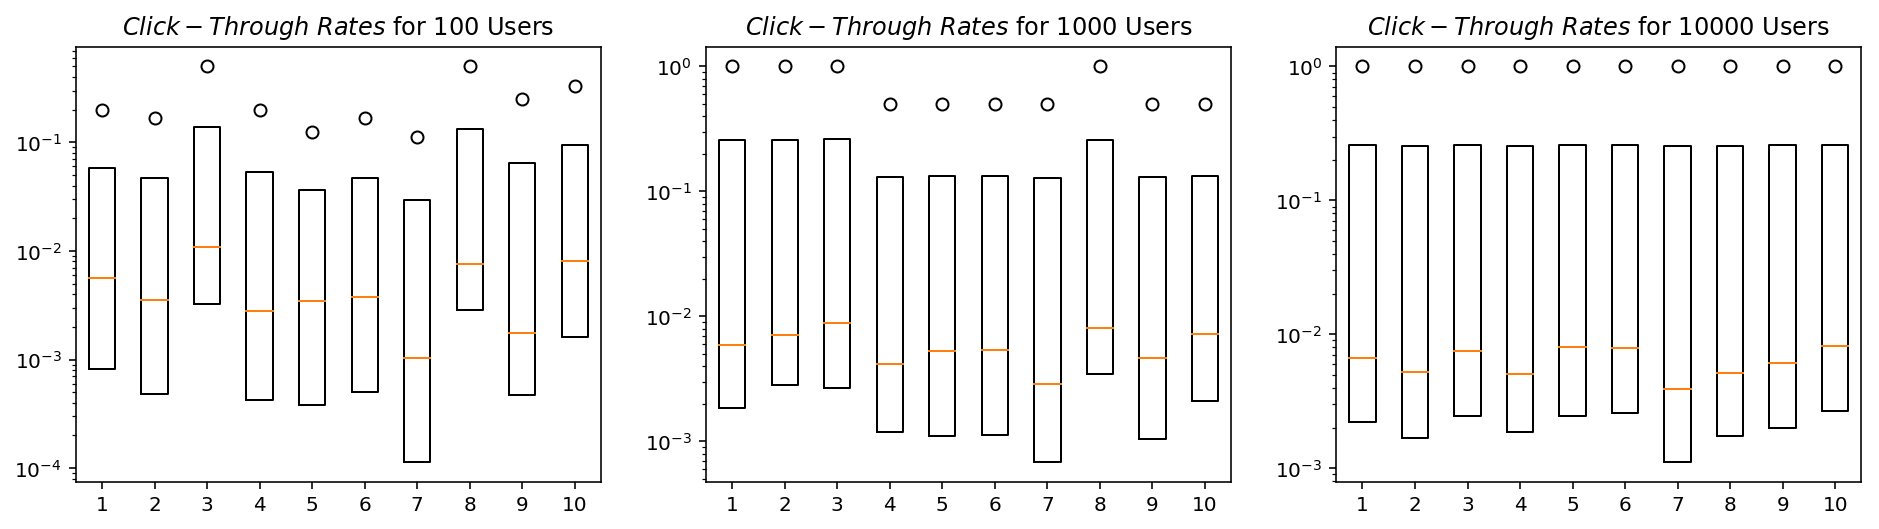

In [10]:
figs, axs = plt.subplots(1, 3, figsize=(16, 4))

for plot_ix, amount_of_users in [(0, 100), (1, 1000), (2, 10000)]:
    ctr_data = deepcopy(env).generate_logs(amount_of_users)
    ctrs = [[] for _ in range(NumberOfProducts)]
    bandits = ctr_data[ctr_data['z'] == 'bandit']
    for user_id in range(amount_of_users):
        user_data = bandits[bandits['u'] == user_id]
        for product_id in range(NumberOfProducts):
            bandits_for_product = user_data[user_data['a'] == product_id]
            if bandits_for_product.shape[0] == 0:
                ctr = 0
            else:
                amount_of_clicks = bandits_for_product[bandits_for_product['c'] == 1].shape[0]
                ctr = float(amount_of_clicks) / bandits_for_product.shape[0]
            ctrs[product_id].append(ctr)
    stats = []
    for product_id in range(NumberOfProducts):
        stats.append(
            (
                np.var(ctrs[product_id]), 
                np.mean(ctrs[product_id]), 
                np.max(ctrs[product_id]), 
                np.min(ctrs[product_id])
            )
        )
    axs[plot_ix].set_title(f'$Click-Through\ Rates$ for {amount_of_users} Users')
    axs[plot_ix].boxplot(stats)
    axs[plot_ix].set_yscale('log')

plt.show()    

Finally, let's build the histogram of the distribution of _`Actions`_ per users.

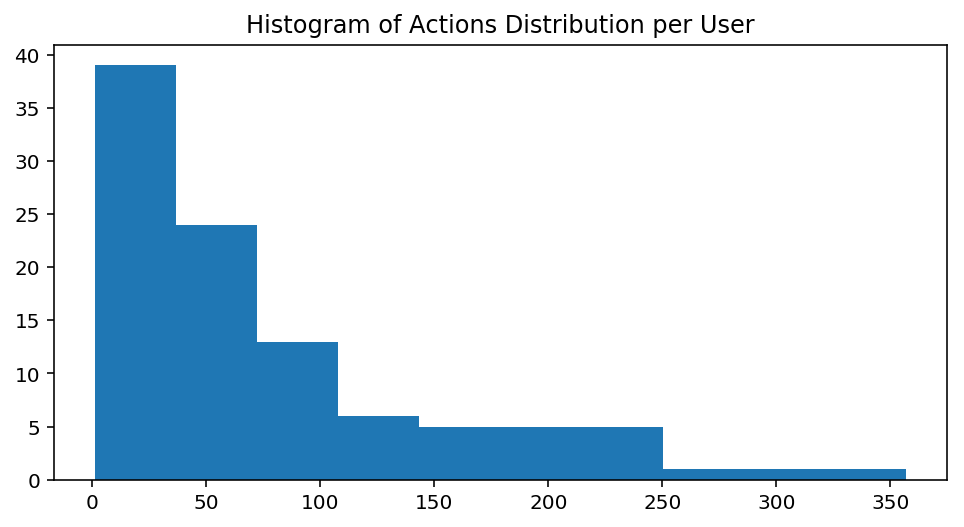

In [11]:
plt.rcParams['figure.figsize'] = [8, 4]
_, ax = plt.subplots()
ax.set_title('Histogram of Actions Distribution per User')

actions_per_user = []
for user_id in range(int(data.u.max()) + 1):
    user_data = bandits[bandits['u'] == user_id]
    user_actions = user_data[user_data['z'] == 'bandit']
    actions_per_user.append(len(user_actions))

ax.hist(actions_per_user)
plt.show()

# Logistic Regression Model

## Turn Data into Features

Now we are going to build a _Logistic Regression_ model.

The model will predict _the probability of the click_ for the following data:
* _`Views`_ is a total amount of views of a particular _`Product`_ shown during _Organic_ _`Events`_ **before** a _Bandit_ _`Event`_.
* _`Action`_ is a proposed _`Product`_ at a _Bandit_ _`Event`_.

For example, assume that we have _`10`_ products. In _Organic_ _`Events`_, these products  were shown to a user as follows:
<table>
    <tr>
        <th>Product ID</th>
        <th>Views</th>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>1</td>
        <td>0</td>
    </tr>
    <tr>
        <td>2</td>
        <td>0</td>
    </tr>
    <tr>
        <td>3</td>
        <td>7</td>
    </tr>
    <tr>
        <td>4</td>
        <td>0</td>
    </tr>
    <tr>
        <td>5</td>
        <td>0</td>
    </tr>
    <tr>
        <td>6</td>
        <td>0</td>
    </tr>
    <tr>
        <td>7</td>
        <td>8</td>
    </tr>
    <tr>
        <td>8</td>
        <td>11</td>
    </tr>
    <tr>
        <td>9</td>
        <td>0</td>
    </tr>
</table>

When we want to know the probability of the click for _`Product`_ = _`8`_ with available amounts of _`Views`_, the input data for the model will be:

_`0 0 0 7 0 0 0 0 8 11 0`_ _**`8`**_

The first 10 numbers are _`Views`_ of _`Products`_ (see above), the latest one is the _`Action`_.

The output will be two numbers:
* $0^{th}$ index: $1 - \mathbb{P}_c(P=p|V)$.
* $1^{st}$ index: $\mathbb{P}_c(P=p|V)$.

Here, $\mathbb{P}_c(P=p|V)$ is the probability of the click for a _`Product`_ $p$, provided that we have _`Views`_ $V$.


In all following models, an _`Action`_ will not be used as a number, but it will be decoded as a _vector_.
In our current example, the _`Action`_ is _`8`_. Thus, it is encoded as:

_`0 0 0 0 0 0 0 0`_ _**`1`**_ _`0`_

Here,
* Vector of _`Actions`_ has a size that is equal to the _*number of `Products`*_ i.e. _`10`_.
* _`Action`_ _`8`_ is marked as _`1`_ (_`Action`_ starts with _`0`_).

In [12]:
import math
import numpy as np


def build_train_data(
        data,
        mark_action_in_views = False,
        with_normalization = False,
        weight_history_function = None
):
    """
    Build Train Data

        Parameters:
            data: offline experiment logs
                the data contains both Organic and Bandit Events
            mark_action_in_views(bool): adds an extra column into a feature set;
                the column has 1 if in an Action that corresponds to a certain Product
                 has at least one preceding View in Organic Events for the current User
            with_normalization(bool): all Views are normalized to the value in range [0; 1];
            weight_history_function(function): weight functions that assigns an appropriate weight
                for View in Organic Event for a certain Product

        Returns:
            :(features, outs)
    """
    num_products = int(data.v.max() + 1)
    number_of_users = int(data.u.max()) + 1

    features = []
    outs = []

    for user_id in range(number_of_users):
        views = np.zeros((0, num_products))
        for _, user_datum in data[data['u'] == user_id].iterrows():
            if user_datum['z'] == 'organic':
                assert (math.isnan(user_datum['a']))
                assert (math.isnan(user_datum['c']))
                assert (not math.isnan(user_datum['v']))

                view = int(user_datum['v'])

                tmp_view = np.zeros(num_products)

                tmp_view[view] = 1

                # Append the latest view at the beginning of all views.
                views = np.append(tmp_view[np.newaxis, :], views, axis = 0)
            else:
                assert (user_datum['z'] == 'bandit')
                assert (not math.isnan(user_datum['a']))
                assert (not math.isnan(user_datum['c']))
                assert (math.isnan(user_datum['v']))

                action = int(user_datum['a'])
                action_flags = np.zeros(num_products, dtype = np.int8)
                action_flags[int(action)] = 1

                click = int(user_datum['c'])

                if weight_history_function is None:
                    train_views = views
                else:
                    history = np.array(range(views.shape[0])).reshape(views.shape[0], 1)
                    weights = weight_history_function(history)
                    train_views = views * weights

                feature = np.sum(train_views, axis = 0)

                if with_normalization:
                    if np.sum(feature) == 0:
                        feature = feature / np.sum(feature)

                feature = np.append(feature, action_flags)

                if mark_action_in_views:
                    feature = np.append(feature, 0 if feature[action] == 0 else 1)

                features.append(feature)
                outs.append(click)

    return np.array(features), np.array(outs)

In [13]:
train_features01, train_outs01 = build_train_data(data)

The sample of the training data you shall find below.

In [14]:
print("Train Features:\n", train_features01[:5])
print("Click Probabilities (Outputs):\n", train_outs01[:5])

Train Features:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Click Probabilities (Outputs):
 [0 0 0 0 0]


Let's examine the train data.

* At time _`0`_, for a _`User`_ = _`0`_ there is an _Organic_ _`Event`_. The _`Event`_ contains a _`View`_ of _`Product`_ = _`4`_.
* At time _`1`_, for the same _`User`_ a new _Bandit_ _`Event`_ goes. Now, when the _Bandit_ _`Event`_ happens, we already have the following _`Views`_: _`0 0 0 0`_ _**`1`**_ _`0 0 0 0 0`_. Next, we apply an _`Action`_ _`6`_ and receive for that _`Action`_ reward (click) _`0`_. Thus, the input for the training of our _Logistic Regression_ model will be:
    * **Input:**
        * _`Views`:_ _`0 0 0 0`_ _**`1`**_ _`0 0 0 0 0`_
        * _`Action`:_ _`0 0 0 0 0 0`_ _**`1`**_ _`0 0 0`_
    * **Output:** _`0`_

* Next, at time _`2`_, a next _Bandit_ _`Event`_ goes. Since we have only one _Organic_ _`Event`_, _`Views`_ have not changed and they remain the same as for the _Bandit_ _`Event`_ at time _`1`_. However, this time we try an _`Action`_ = _`3`_. Thus, the training data looks as follows:
    * **Input:**
        * _`Views`:_ _`0 0 0 0`_ _**`1`**_ _`0 0 0 0 0`_
        * _`Action`:_ _`0 0 0`_ _**`1`**_ _`0 0 0 0 0 0`_
    * **Output:** _`0`_

In [15]:
from sklearn.linear_model import LogisticRegression

logreg_base = LogisticRegression(
    solver = 'lbfgs',
    max_iter = 2000,
    random_state = RandomSeed
)

lr_base = logreg_base.fit(train_features01, train_outs01)

Let's check how the _Logistic Regression_ model works.

In [16]:
# Check the probability of getting a click for Product ID '2' with 10 observations for that Product.
test_features01 = np.zeros((1, 2 * NumberOfProducts))

test_features01[:, 2] = 10
test_features01[:, NumberOfProducts + 2] = 1
test_out01 = lr_base.predict_proba(test_features01)

print("Test Features:\n", test_features01)
print("Click Probabilities (Outputs): ", test_out01)

Test Features:
 [[ 0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  0.]]
Click Probabilities (Outputs):  [[0.99753919 0.00246081]]


Below you shall find a plot of _the probability of the click_ for different _`Products`_.

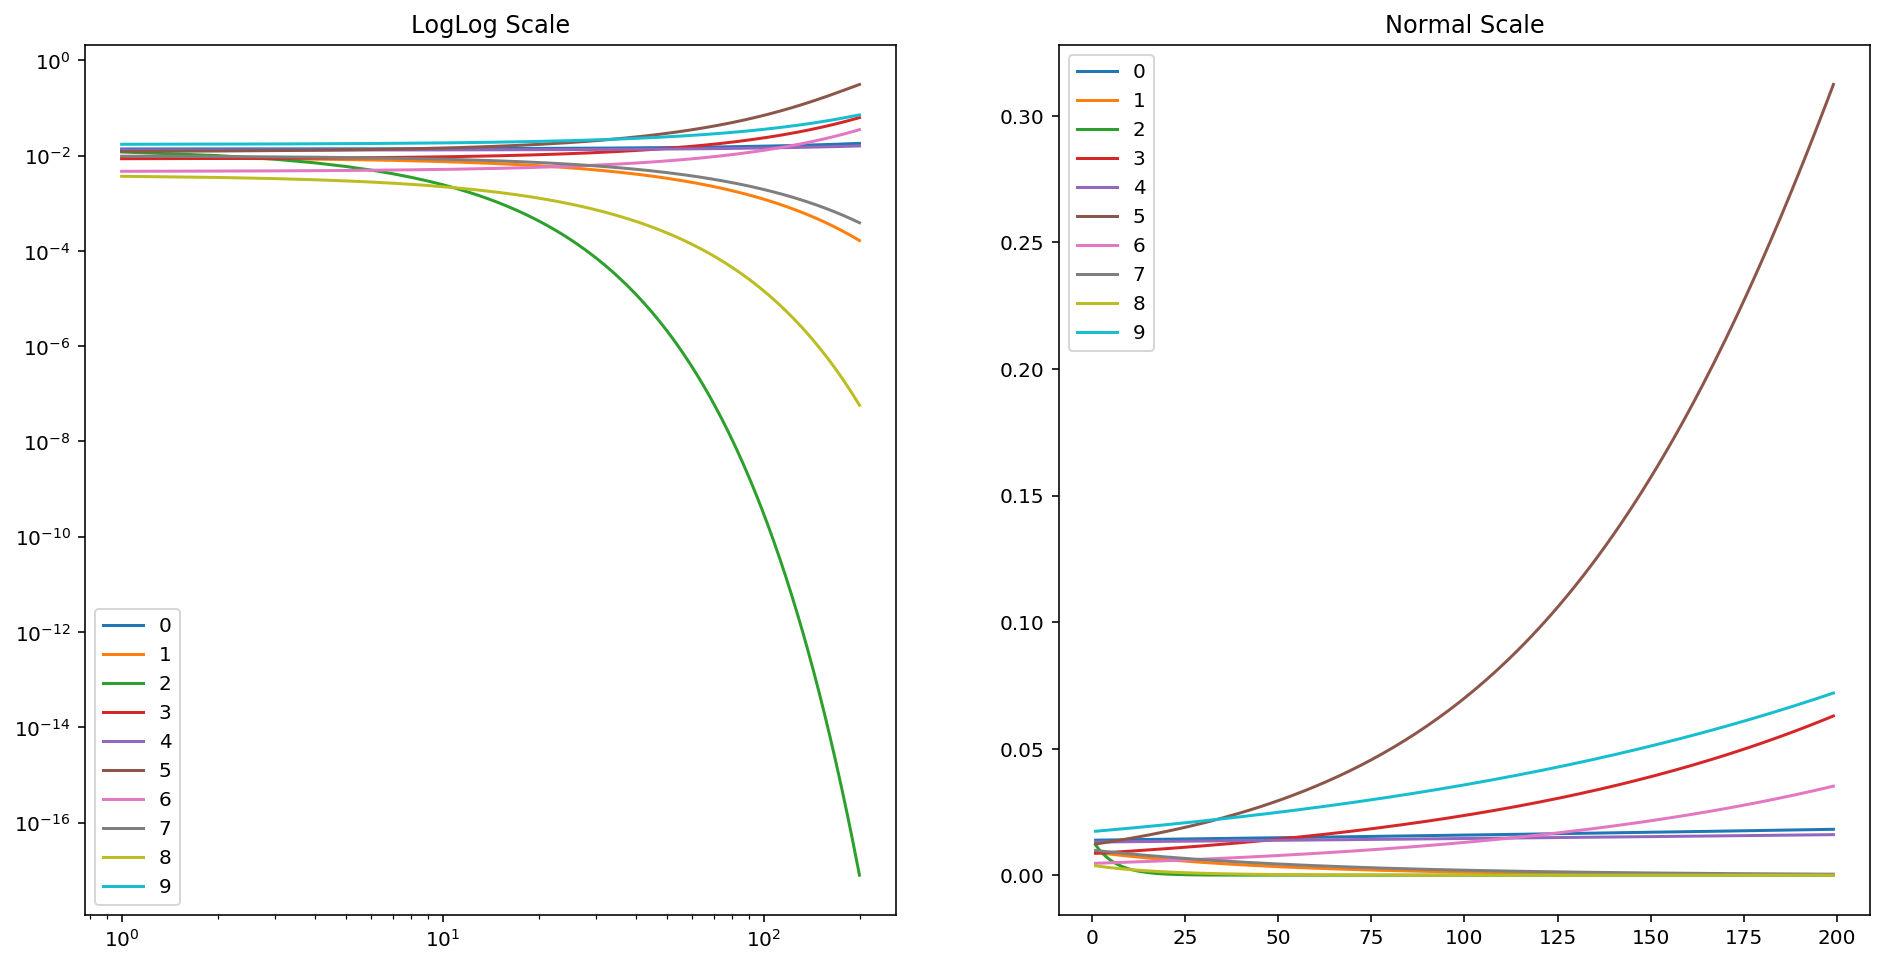

In [17]:
figs, axs = plt.subplots(1, 2, figsize=(16, 8))

for product_id in range(NumberOfProducts):
    counts = []
    prob1s = []
    test_data = np.zeros((1, 2 * NumberOfProducts))
    test_data[:, NumberOfProducts + product_id] = 1
    for count in range(1, 200):
        test_data[:, product_id] = count
        test_out = lr_base.predict_proba(test_data)
        counts.append(count)
        prob1s.append(test_out[0][1])

    axs[0].loglog(counts, prob1s, label = f"{product_id}")
    axs[1].plot(counts, prob1s, label = f"{product_id}")

labels = [f"{ix}" for ix in range(NumberOfProducts)]
axs[0].set_title(f'LogLog Scale')
axs[0].legend(labels)
axs[1].set_title(f'Normal Scale')
axs[1].legend(labels)
pylab.show()

In [18]:
lr_base.coef_

array([[ 0.00138673, -0.02022126, -0.1766234 ,  0.01031782,  0.00103055,
         0.01816621,  0.01032815, -0.01629967, -0.05590587,  0.00747378,
         0.35369684, -0.06047891,  0.38343053, -0.13236319,  0.2983782 ,
         0.21810418, -0.74501919,  0.01727666, -0.92078218,  0.57797292]])

As you can see, the _probability of the click_ grows quite slowly for most of _`Products`_ as grows the amount of _`Views`_ or these _`Products`_ in _Organic_ _`Events`_.

## Frequency of _`Views`_

In a new model, _`Views`_ are normalised: instead of using an exact number of _`Views`_, a frequency of _`Views`_ is used:

$$ \tilde{v}_i = \frac{v_i}{\sum_{p \in P}v_p} $$

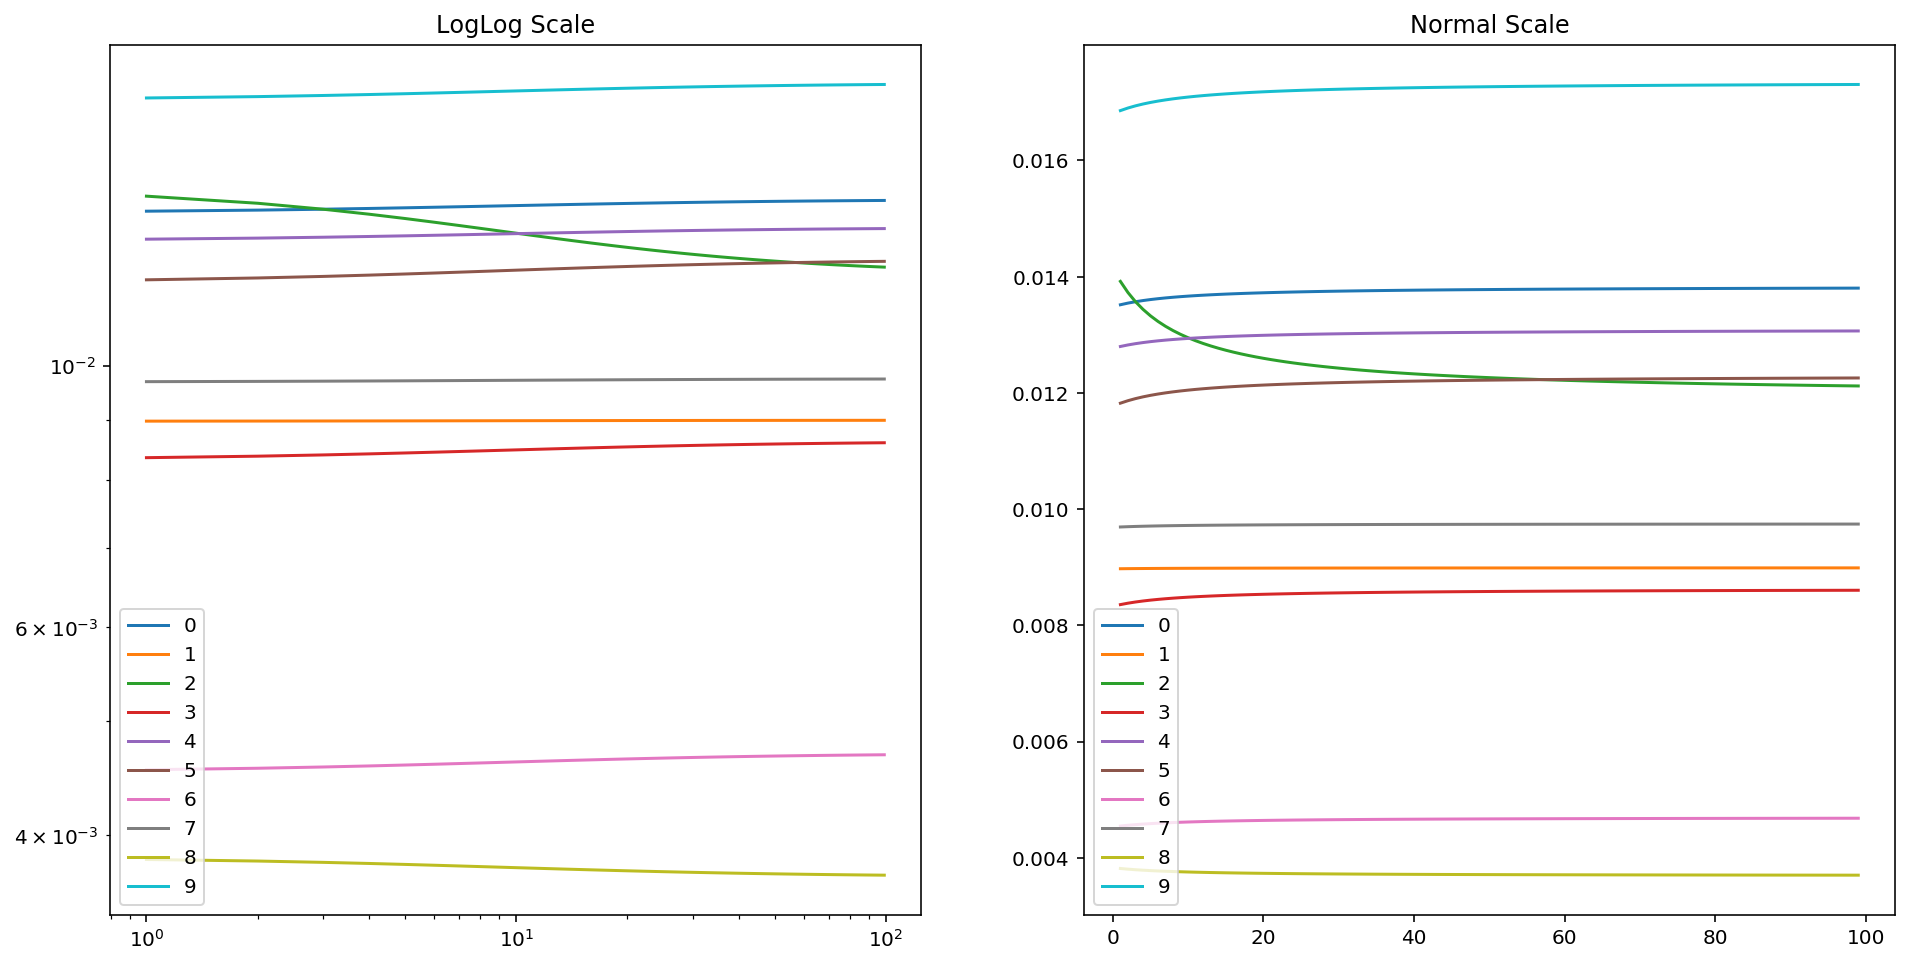

In [19]:
test_features02, test_outs02 = build_train_data(data, False, True)

logreg_freq = LogisticRegression(
    solver = 'lbfgs',
    max_iter = 2000,
    random_state = RandomSeed
)

lr_freq = logreg_freq.fit(test_features02, test_outs02)

figs, axs = plt.subplots(1, 2, figsize = (16, 8))

for product_id in range(NumberOfProducts):
    counts = []
    prob1s = []
    test_data = np.zeros((1, 2 * NumberOfProducts))
    test_data[:, NumberOfProducts + product_id] = 1
    test_data[:, :NumberOfProducts] = 1  # Set 1 for ALL products.
    for count in range(1, 100):
        test_data[:, product_id] = count
        norm_test_data = test_data.copy()
        norm_test_data[:, :NumberOfProducts] = test_data[:, :NumberOfProducts] / np.sum(test_data[:, :NumberOfProducts])
        test_out = lr_freq.predict_proba(norm_test_data)
        counts.append(count)
        prob1s.append(test_out[0][1])

    axs[0].loglog(counts, prob1s)
    axs[1].plot(counts, prob1s)

axs[0].set_title(f'LogLog Scale')
axs[0].legend(labels)
axs[1].set_title(f'Normal Scale')
axs[1].legend(labels)
plt.show()
plt.show()

In [20]:
lr_freq.coef_

array([[ 0.00138673, -0.02022126, -0.1766234 ,  0.01031782,  0.00103055,
         0.01816621,  0.01032815, -0.01629967, -0.05590587,  0.00747378,
         0.35369684, -0.06047891,  0.38343053, -0.13236319,  0.2983782 ,
         0.21810418, -0.74501919,  0.01727666, -0.92078218,  0.57797292]])

## The Mark of the Presence of an _`Action`_ in _`Views`_

So far, the features were based on _`Views`_ and _`Actions`_ _irrespectively_ to the presence of any _`View`_ that corresponds to the _`Action`_.

At this time, we will introduce a new mark into features: _the Marker of the Presence of an `Action` in `Views`_ and set it as follows:
* _**`1`**_ if an _`Action`_ that corresponds to a certain _`Product`_ was present at least once in preceding _Organic_ _`Events`_.
* _**`0`**_ in another case.


**E.G.:**
For previously considered data, we will have the following:
* At time _`8`_:
    * **Input:**
        * _`Views`:_ _`0 0 0 0`_ _**`1`**_ _`0 0 `_ _**`1`**_ _**`3`**_ _`0`_
        * _`Action`:_ _`0 0 0 0`_ _**`1`**_ _`0 0 0 0 0`_
        * _`Mark`:_ _**`1`**_ (there is _`1`_ in _`View`_ for _`Product`_ = _`4`_)
    * **Output:** _`0`_
* At time _`9`_:
    * **Input:**
        * _`Views`:_ _`0 0 0 0`_ _**`1`**_ _`0 0 `_ _**`1`**_ _**`3`**_ _`0`_
        * _`Action`:_ _`0 0 0 0 0 0`_ _**`1`**_ _`0 0 0`_
        * _`Mark`:_ _**`0`**_ (there is **no** any _`View`_ for _`Product`_ = _`6`_)
    * **Output:** _`0`_

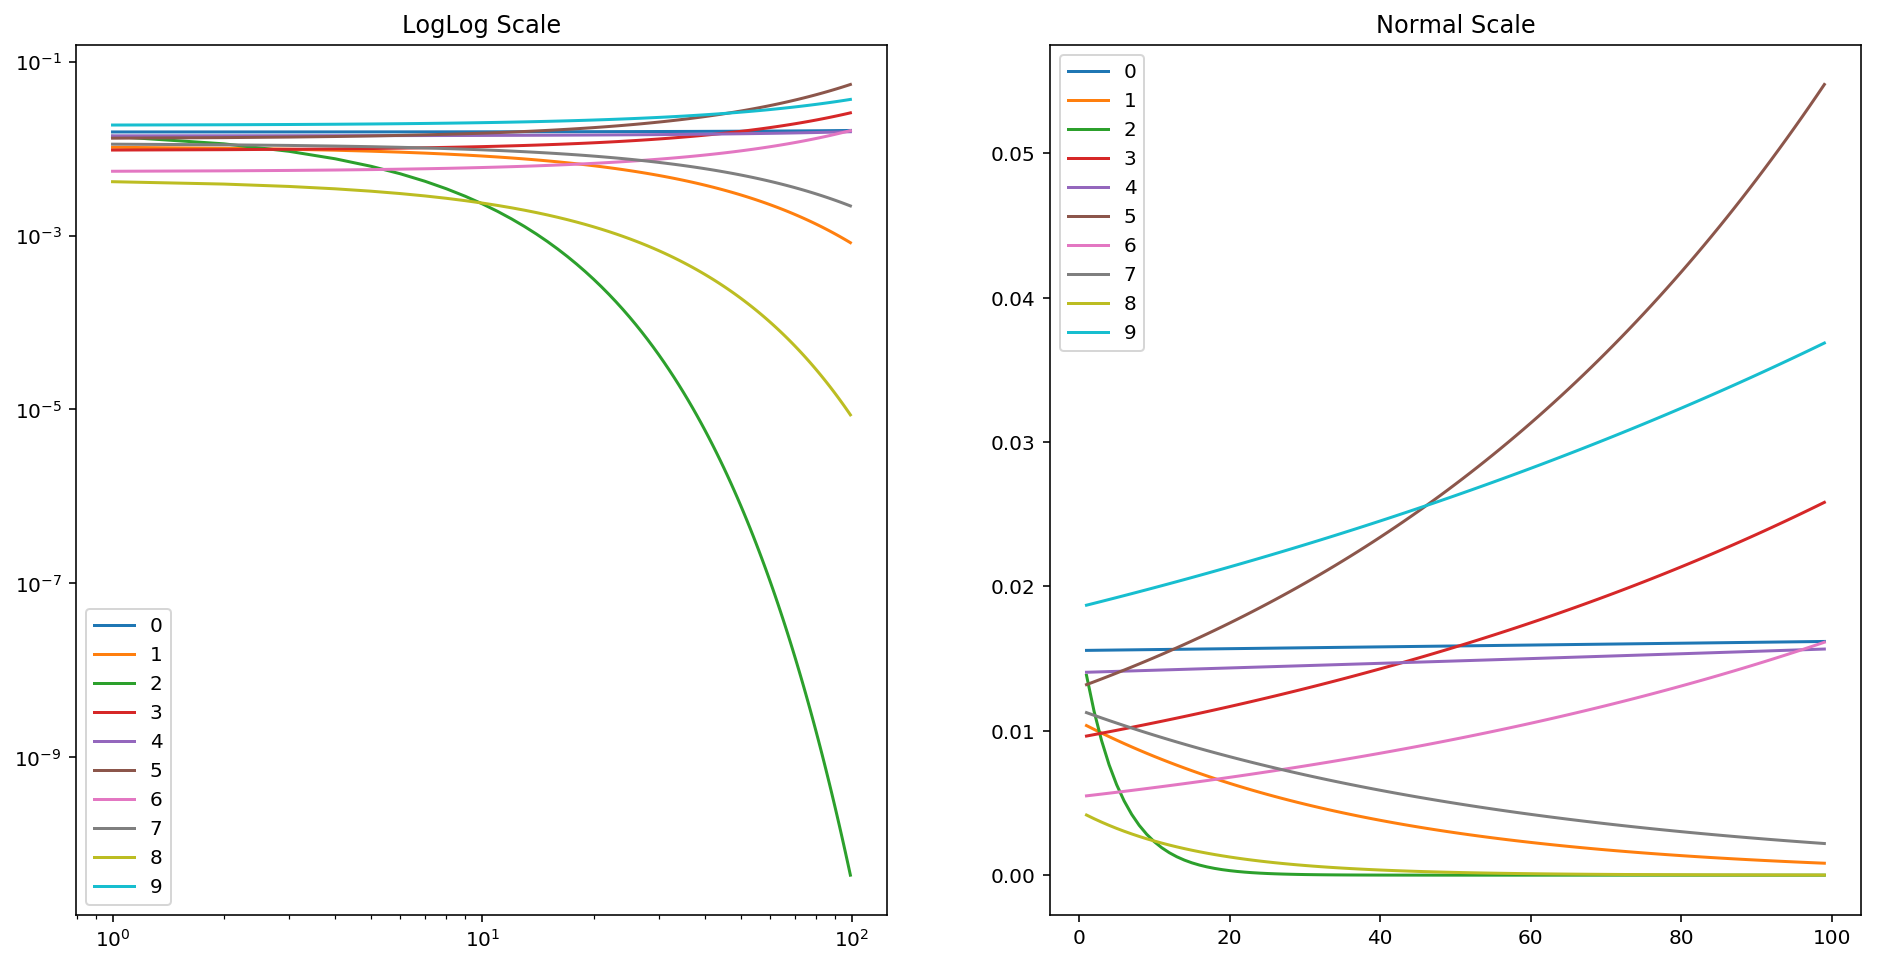

In [21]:
test_features03, test_outs03 = build_train_data(data, True)

logreg_with_mark = LogisticRegression(
    solver = 'lbfgs',
    max_iter = 2000,
    random_state = RandomSeed
)

lr_with_mark = logreg_with_mark.fit(test_features03, test_outs03)

figs, axs = plt.subplots(1, 2, figsize=(16, 8))

for product_id in range(NumberOfProducts):
    counts = []
    prob1s = []
    test_data = np.zeros((1, 2 * NumberOfProducts + 1)) # The lattest column is the marker.
    test_data[:, NumberOfProducts + product_id] = 1
    test_data[:, 2 * NumberOfProducts] = 1
    for count in range(1, 100):
        test_data[:, product_id] = count
        test_out = logreg_with_mark.predict_proba(test_data)
        counts.append(count)
        prob1s.append(test_out[0][1])

    axs[0].loglog(counts, prob1s)
    axs[1].plot(counts, prob1s)

axs[0].set_title(f'LogLog Scale')
axs[0].legend(labels)
axs[1].set_title(f'Normal Scale')
axs[1].legend(labels)
plt.show()

In [22]:
lr_with_mark.coef_

array([[ 4.03763530e-04, -2.58843200e-02, -1.99886386e-01,
         1.02272389e-02,  1.12196119e-03,  1.49604694e-02,
         1.11029131e-02, -1.67894194e-02, -6.30793465e-02,
         7.11487097e-03,  3.51700433e-01, -3.44386119e-02,
         4.32663424e-01, -1.43990420e-01,  2.47044181e-01,
         1.69419016e-01, -7.10966229e-01,  4.03827137e-02,
        -9.14672444e-01,  5.31364350e-01,  1.63742766e-01]])

### Polynomial Feature Set

Previously, a linear set of features was considered. Now we are going to analyse a polynomial set of features, i.e. the set of the features those are either in the second degree or those are in a specific combination with each other.

In [23]:
from sklearn.preprocessing import PolynomialFeatures

test_features04, test_outs04 = build_train_data(data)

# Instantiate Polynomial feature of the 2nd degree.
poly2 = PolynomialFeatures(2)
test_features_poly = poly2.fit_transform(test_features04)

Let's examine the set of _features_.

In [24]:
print("Features of Training Data in 2nd Polinomial Degree:\n", test_features_poly[1, :])
print("Features of Training Data in 2nd Polinomial Degree Shape:", test_features_poly.shape)

only_first_degree = np.sum(poly2.powers_, axis=1) == 1
only_with_actions = np.sum(poly2.powers_[:, NumberOfProducts:], axis=1) == 1
feature_selection_flags = only_first_degree | only_with_actions
print("Feature of Training Data Selection Flags: ", feature_selection_flags)

print("Features of Training Data in 2nd Polinomial Degree with Selection:\n", test_features_poly[1, feature_selection_flags])
print("Features of Training Data in 2nd Polinomial Degree with Selection Shape:", test_features_poly[:, feature_selection_flags].shape)

Features of Training Data in 2nd Polinomial Degree:
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Features of Training Data in 2nd Polinomial Degree Shape: (7561, 231)
Feature of Training Data Selection Flags:  [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True Fa

As you see, there are _`231`_ features in the second polynomial degree. However, we do not use all of them. Instead, we use the following features:
* all features in the 1st degree (_`Views`_ and _`Action`_ as a vector)
* all cross features of _`Views`_ with _`Action`_ as a vector


That _explicit_ features selection reduces the number of features to _`120`_.

In [25]:
logreg = LogisticRegression(
    solver = 'lbfgs',
    max_iter = 5000,
    random_state = RandomSeed
)

lr_poly = logreg.fit(test_features_poly[:, feature_selection_flags], test_outs04)

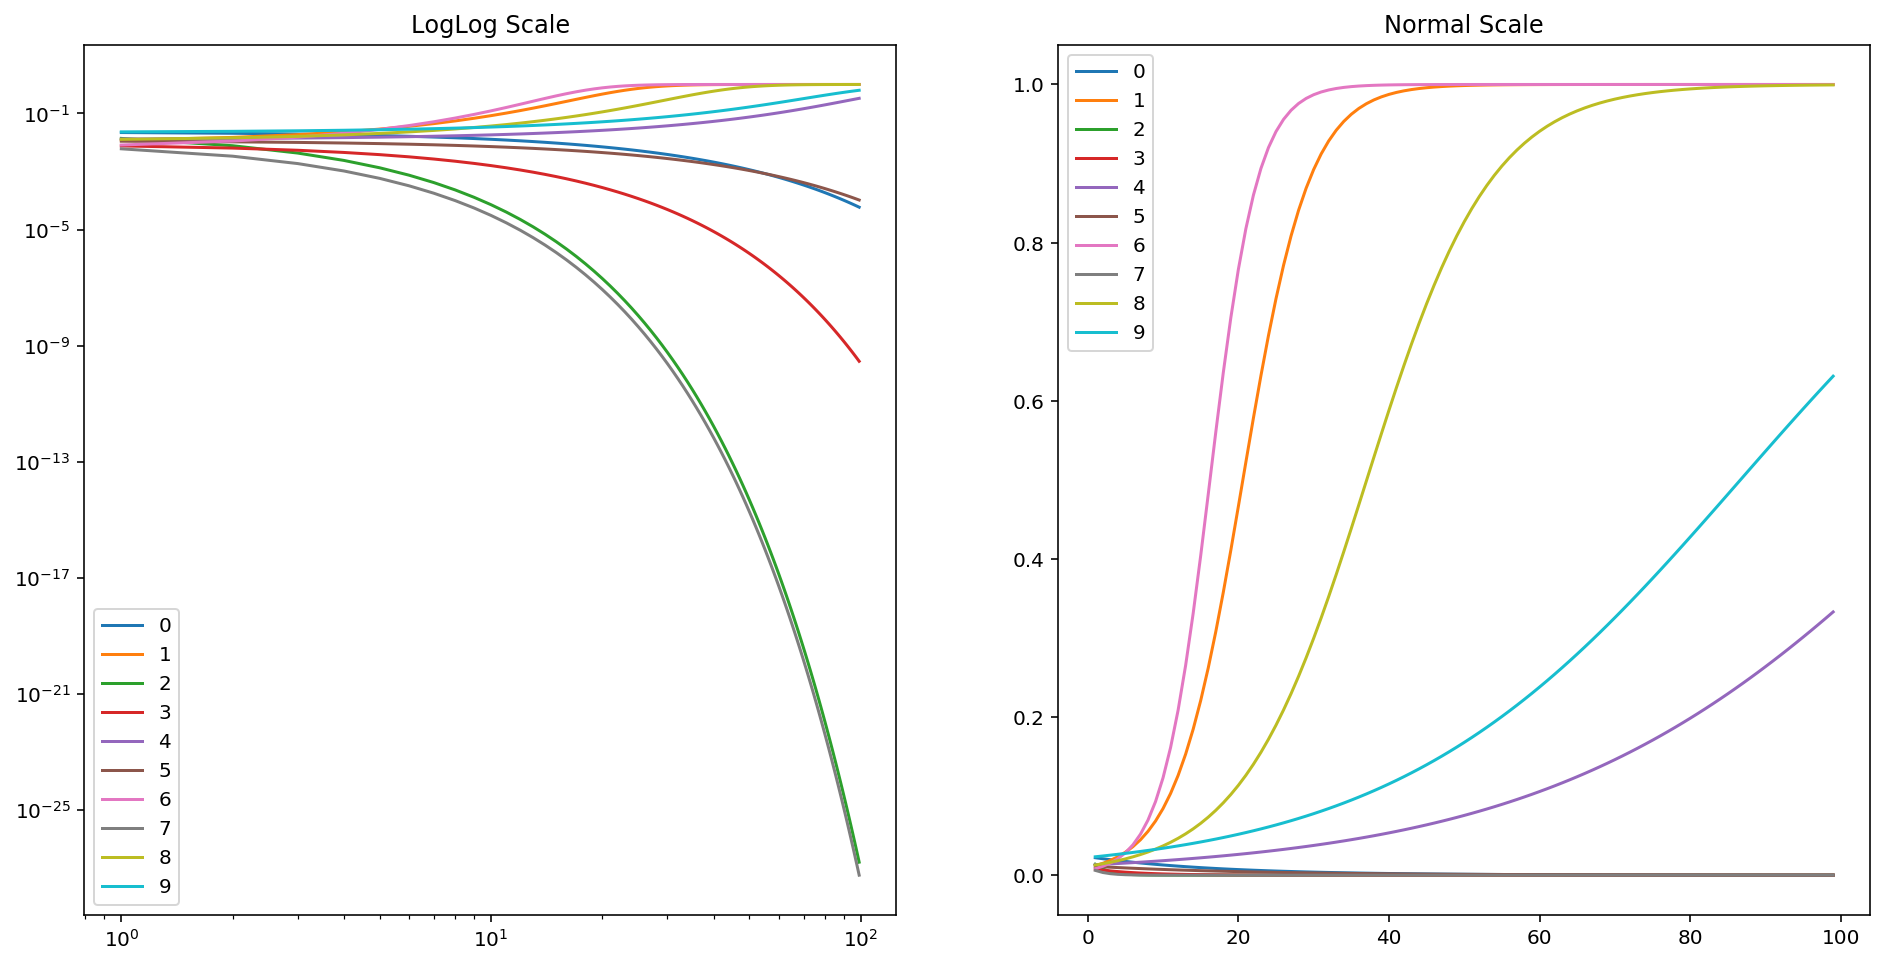

In [26]:
np.seterr(over = 'ignore')

figs, axs = plt.subplots(1, 2, figsize=(16, 8))

for product_id in range(NumberOfProducts):
    counts = []
    prob1s = []
    test_data = np.zeros((1, 2 * NumberOfProducts))
    test_data[:, NumberOfProducts + product_id] = 1
    for count in range(1, 100):
        test_data[:, product_id] = count
        test_out = lr_poly.predict_proba(poly2.fit_transform(test_data)[:, feature_selection_flags])
        counts.append(count)
        prob1s.append(test_out[0][1])

    axs[0].loglog(counts, prob1s)
    axs[1].plot(counts, prob1s)

axs[0].set_title(f'LogLog Scale')
axs[0].legend(labels)
axs[1].set_title(f'Normal Scale')
axs[1].legend(labels)
plt.show()

In [27]:
lr_poly.coef_

array([[-9.89004146e-02, -3.59693872e-01, -2.10192774e-01,
        -7.12418552e-02, -2.66969461e-02, -4.16045779e-02,
        -9.04106686e-02, -2.32565292e-01,  5.83424112e-03,
        -6.26386534e-02,  6.09872469e-01, -2.94634182e-01,
         6.61070120e-01, -3.51302526e-01, -8.96580397e-03,
        -1.03851888e-01, -7.69066843e-01, -1.69715378e-01,
        -1.22263290e-01,  5.59916182e-01,  3.82140151e-02,
         1.04451668e-01,  7.15412599e-02, -2.67425826e-01,
         1.51753947e-01,  1.21806888e-01, -2.07213831e-01,
         9.70327313e-02, -3.32599746e-01,  1.23538479e-01,
         8.27753325e-01,  5.84729023e-01, -3.74794694e-01,
        -6.23243172e-01, -9.42251935e-01, -5.89333644e-01,
         1.75142488e-02,  6.52623119e-01, -2.26040032e-01,
         3.13349890e-01,  6.08595171e-01, -8.82181147e-02,
        -3.76125684e-01, -2.62028247e-01, -2.92053322e-01,
         5.02085436e-01, -2.15931264e-01, -1.06250453e-01,
        -5.54381285e-02,  7.51718319e-02,  1.42472348e-0

This time, all _`Actions`_ uniformly react on the increase of _`Views`_: the _the probability of the click_ grows as grows the amount of _`Views`_.

# Agent Comparision

In this section, we are going to compare the performance of different _`Agents`_ those apply different policies to select an appropriate _`Action`_ for a _Bandit_ _`Event`_.

As a measurement of the _`Agent`_ performance, we will use _Click Trhough Rate_ (_CTR_) that is defined as following:
$$ CTR = \frac{\sum_{B}{\mathbb{1}_c}}{\big|B\big|} $$

Here
* $\sum_{B}{\mathbb{1}_c}$ is a total amount of clicks for all _Bandit_ _`Events`_
* $\big|B\big|$ is a total amount of all _Bandit_ _`Events`_

## Agent based on Organic Events Model

So far, we have estimated _Logistig Regression_ models and evaluated different feature sets:
* _`Views`_ and _`Action`_
* _`Views`_ **as frequencies** and _`Action`_ 
* _`Views`_, _`Action`_, and _**the mark of the presence of an `Action` in `Views`**_ 
* _`Views`_ and _`Action`_ _**as a polynomial set**_

Now, we consider a so-called _Organic Agent_. The idea of the _`Agent`_ is following:
* whenever a new _Organic_ _`Event`_ happens, the _`View`_ for a particular _Product_ is incremented
* whenever a new _Bandit_ _`Event`_ happens, we provide an _`Action`_ that corresponds to the most frequently shown _`Product`_

Now, let's create a new _`Agent`_ that incorporates that logic explicitly.

In [28]:
import numpy as np
from numpy.random.mtrand import RandomState
from reco_gym import Configuration
from agents import Agent

class OrganicEventCounterAgent(Agent):
    """
    Organic Event Counter Agent
    
    The Agent that counts Organic views of Products
    and selects an Action for the most frequently shown Product.
    """
    def __init__(self, config):
        super(OrganicEventCounterAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        self.organic_views = np.zeros(self.config.num_products)

    def observe(self, observation):
        for session in observation.sessions():
            self.organic_views[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        prob = self.organic_views / sum(self.organic_views)
        action = self.rng.choice(self.config.num_products, p = prob)
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.organic_views = np.zeros(self.config.num_products)

In [29]:
abtest_data = deepcopy(env).generate_logs(ABTestNumberOfUsers, OrganicEventCounterAgent(Configuration(env_1_args)))

It is evident in logs; the _Agent_ provides an _`Action`_ that corresponds to the _`Product`_ that was most frequently shown in _Organic_ _`Events`_.

## Agent Based on Logistic Regression Model

Let's create _`Agents`_ those use _Logistic Regression_ models based on the set of features we have already examined and compare their performance with _Organic_ _`Agent`_.

In [30]:
from agents import FeatureProvider

class ViewsFeatureProvider(FeatureProvider):
    """Feature provider as an abstract class that defined interface of setting/getting features"""

    def __init__(self, config):
        super(ViewsFeatureProvider, self).__init__(config)
        self.feature_data = None

    def observe(self, observation):
        """Consider an Organic Event for a particular user"""
        for session in observation.sessions():
            self.feature_data[:, session['v']] += 1

    def features(self, observation):
        """Provide feature values adjusted to a particular feature set"""
        return self.feature_data


class ViewsAndActionAsVectorFeatureProvider(ViewsFeatureProvider):
    """Feature Provider for feature set defined as Views and an Action as a Vector"""

    def __init__(self, config):
        super(ViewsAndActionAsVectorFeatureProvider, self).__init__(config)

    def reset(self):
        self.feature_data = np.zeros((self.config.num_products, 2 * self.config.num_products))
        for ix in range(self.config.num_products):
            self.feature_data[ix, self.config.num_products + ix] = 1


class ViewFrequenciesAndActionAsVectorFeatureProvider(ViewsAndActionAsVectorFeatureProvider):
    def __init__(self, env):
        super().__init__(env)

    def features(self, observation):
        base_features = super().features(observation)
        views = base_features[:, :self.config.num_products]
        views = views / np.sum(views, axis = 1)
        base_features[:, :self.config.num_products] = views
        return base_features


class ViewsAndActionAsVectorWithMarkFeatureProvider(ViewsAndActionAsVectorFeatureProvider):
    def __init__(self, config):
        super(ViewsAndActionAsVectorWithMarkFeatureProvider, self).__init__(config)

    def features(self, observation):
        base_features = super().features(observation)
        marks = np.zeros((self.config.num_products, 1))
        for product_id in range(self.config.num_products):
            if base_features[product_id, product_id] > 0:
                marks[product_id, 0] = 1

        base_features = np.append(base_features, marks, axis = 1)
        return base_features


class ViewsAndActionPolynomialFeatureProvider(ViewsAndActionAsVectorFeatureProvider):
    """Feature Provider for polynomial feature set defined as Views and an Action"""

    def __init__(self, env, flags, degree = 2):
        super().__init__(env)
        self.poly = PolynomialFeatures(degree)
        self.flags = flags

    def features(self, observation):
        return self.poly.fit_transform(super().features(observation))[:, self.flags]


class ModelBasedAgent(Agent):
    def __init__(self, env, feature_provider, model):
        # Set environment as an attribute of Agent.
        self.env = env
        self.feature_provider = feature_provider
        self.model = model
        self.reset()

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past history"""
        self.feature_provider.observe(observation)
        prob = self.model.predict_proba(self.feature_provider.features(observation))[:, 1]
        action = np.argmax(prob)
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            }
        }

    def reset(self):
        self.feature_provider.reset()

Below, there is the definition of the function that applies A/B tests for different _`Agents`_ and calculates _Click-Through Rate_.

In [31]:
import pandas as pd
from scipy.stats.distributions import beta

def verify_agents(env, number_of_users, agents):
    stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }

    for agent_id in agents:
        stat['Agent'].append(agent_id)
        data = deepcopy(env).generate_logs(number_of_users, agents[agent_id])
        bandits = data[data['z'] == 'bandit']
        successes = bandits[bandits['c'] == 1].shape[0]
        failures = bandits[bandits['c'] == 0].shape[0]
        stat['0.025'].append(beta.ppf(0.025, successes + 1, failures + 1))
        stat['0.500'].append(beta.ppf(0.500, successes + 1, failures + 1))
        stat['0.975'].append(beta.ppf(0.975, successes + 1, failures + 1))
        
    return pd.DataFrame().from_dict(stat)

In [32]:
from reco_gym import env_1_args

agen_stats00 = verify_agents(
    env,
    ABTestNumberOfUsers,
    {
        'Organic User Event Counter': OrganicEventCounterAgent(Configuration(env_1_args)),
        'LogReg: Views & Action':
            ModelBasedAgent(
                env_1_args,
                ViewsAndActionAsVectorFeatureProvider(Configuration(env_1_args)),
                lr_base
            ),
        'LogReg: Views as Frequencies & Action':
            ModelBasedAgent(
                env_1_args,
                ViewFrequenciesAndActionAsVectorFeatureProvider(Configuration(env_1_args)),
                lr_freq
            ),
        'LogReg: Views & Action & Mark of Presence':
            ModelBasedAgent(
                env_1_args,
                ViewsAndActionAsVectorWithMarkFeatureProvider(Configuration(env_1_args)),
                lr_with_mark
            ),
        'LogReg: Views & Action (as 2nd Polynom)':
            ModelBasedAgent(
                env_1_args,
                ViewsAndActionPolynomialFeatureProvider(Configuration(env_1_args), feature_selection_flags),
                lr_poly
            )
    })

In [33]:
agen_stats00

,0.025,0.500,0.975,Agent
0,0.012919,0.015678,0.018798,Organic User Event Counter
1,0.009607,0.011966,0.014679,LogReg: Views & Action
2,0.009607,0.011966,0.014679,LogReg: Views as Frequencies & Action
3,0.009607,0.011966,0.014679,LogReg: Views & Action & Mark of Presence
4,0.009257,0.011578,0.014254,LogReg: Views & Action (as 2nd Polynom)


Indeed, the _`Agent`_ that utilises a model based on a feature set with 2nd-degree polynomial has the best performance.

## History of _Organic_ _`Events`_

In previous models, all _`Views`_ of _`Products`_ in _Organic_ _`Events`_ were considered equally _irrespectively_ to the history when a _`Product`_ was shown.

At this time, we are going to compare models with different treating of the notion of the _`View`_ _history_.

The model based on the feature set of the 2nd-degree polynomial as it has revealed the best performance.

For each _`View`_ a weight will be assigned.

The following cases are considered:
* $w(t) = \frac{1}{1 + t}$
* $w(t) = \frac{1}{1 + \ln(1 + t)}$
* $w(t) = \begin{cases}
    1,& \text{if } t < L\\
    0,              & \text{otherwise}
\end{cases}$

Time $t$ will be counted from _`0`_ from the latest _Organic_ _`Event`_ to the past, each time incremented by _`+1`_.

In [34]:
class WeightedViewsAndActionPolynomialFeatureProvider(FeatureProvider):
    """Feature Provider for polynomial feature set defined as Views and an Action"""

    def __init__(self, config, flags, weight_history_function, degree = 2):
        super().__init__(config)
        self.poly = PolynomialFeatures(degree)
        self.flags = flags
        self.weight_history_function = weight_history_function
        self.views = np.zeros((0, self.config.num_products))

    def observe(self, observation):
        """Consider an Organic Event for a particular user"""
        for session in observation.sessions():
            tmp_view = np.zeros(self.config.num_products)
            tmp_view[session['v']] = 1

            self.views = np.append(tmp_view[np.newaxis, :], self.views, axis = 0)

    def reset(self):
        self.views = np.zeros((0, self.config.num_products))

    def features(self, observation):
        base_features = np.zeros((self.config.num_products, 2 * self.config.num_products))
        for ix in range(self.config.num_products):
            base_features[ix, self.config.num_products + ix] = 1

        history = np.array(range(self.views.shape[0])).reshape(self.views.shape[0], 1)
        weights = self.weight_history_function(history)
        weighted_views = np.sum(self.views * weights, axis = 0)
        base_features[:, :self.config.num_products] = weighted_views
        return self.poly.fit_transform(base_features)[:, self.flags]


def build_history_agent(env_args, data, weight_fynction):
    features, outs = build_train_data(data, False, False, weight_fynction)

    config = Configuration(env_args)
    logreg = LogisticRegression(
        solver = 'lbfgs',
        max_iter = 5000,
        random_state = config.random_seed
    )

    poly = PolynomialFeatures(2)
    features_poly = poly.fit_transform(features)
    
    only_first_degree = np.sum(poly.powers_, axis=1) == 1
    only_with_actions = np.sum(poly.powers_[:, NumberOfProducts:], axis=1) == 1
    flags = only_first_degree | only_with_actions

    lr_weight_poly = logreg.fit(features_poly[:, flags], outs)

    return ModelBasedAgent(
        config,
        WeightedViewsAndActionPolynomialFeatureProvider(config, flags, weight_fynction),
        lr_weight_poly
    )


def slide_window(t, L):
    weights = np.zeros((t.shape[0], 1))
    weights[:L, :] = 1
    return weights


def apply_new_environment(new_env_args):
    new_env_1_args = {
        **env_1_args,
        **new_env_args,
    }

    new_env = deepcopy(env)
    new_env.init_gym(new_env_1_args)
    data = deepcopy(new_env).generate_logs(ABTestNumberOfUsers) 
    stat = verify_agents(
        new_env,
        ABTestNumberOfUsers,
        {
            'Organic User Event Counter': OrganicEventCounterAgent(Configuration({
                **new_env_1_args
            })),
            'LogReg Poly & w ~ 1/(1 + t)':
                build_history_agent(new_env_1_args, data, lambda t: 1.0 / (1 + t)),
            'LogReg Poly & w ~ 1/(1 + ln(1 + t))':
                build_history_agent(new_env_1_args, data, lambda t: 1.0 / (1 + np.log(1 + t))),
            'LogReg Poly & w is Latest 20 Organic Events':
                build_history_agent(new_env_1_args, data, lambda t: slide_window(t, 20)),
            'LogReg Poly & w is the latest Organic Event':
                build_history_agent(new_env_1_args, data, lambda t: slide_window(t, 1)),
        })
    return stat

### Case #1

In [35]:
agent_stats01 = apply_new_environment({
    'num_products': 20,
    'number_of_flips': 10,
})

In [36]:
agent_stats01

,0.025,0.500,0.975,Agent
0,0.005494,0.007324,0.009518,Organic User Event Counter
1,0.017077,0.020258,0.023803,LogReg Poly & w ~ 1/(1 + t)
2,0.017077,0.020258,0.023803,LogReg Poly & w ~ 1/(1 + ln(1 + t))
3,0.016938,0.020107,0.023639,LogReg Poly & w is Latest 20 Organic Events
4,0.017077,0.020258,0.023803,LogReg Poly & w is the latest Organic Event


### Case #2

In [37]:
agent_stats02 = apply_new_environment({
    'num_products': 10,
    'number_of_flips': 5,
})

In [38]:
agent_stats02

,0.025,0.500,0.975,Agent
0,0.008740,0.011031,0.013688,Organic User Event Counter
1,0.007911,0.010089,0.012630,LogReg Poly & w ~ 1/(1 + t)
2,0.007810,0.009960,0.012469,LogReg Poly & w ~ 1/(1 + ln(1 + t))
3,0.007691,0.009826,0.012320,LogReg Poly & w is Latest 20 Organic Events
4,0.009081,0.011409,0.014099,LogReg Poly & w is the latest Organic Event


# Conclusion

Different feature sets were investigated for _Likelihood_ model and it was concluded that the polynomial feature set is the best one.

It was also investigated how a history of _Organic_ _`Events`_ influences on the performance of the likelihood model.